In [1]:
import pandas as pd

In [2]:
#import annotazioni e gold standard 
'''
annotazioni= pd.read_csv('https://raw.githubusercontent.com/GConte47/tirocinio/refs/heads/master/df%20omap/files/annotazioni_full.csv', delimiter=',')
GS= pd.read_csv('https://raw.githubusercontent.com/GConte47/tirocinio/refs/heads/master/df%20omap/files/gold_standard.csv', delimiter=',')
'''
#import annotazioni e gold standard
annotazioni= pd.read_csv('../files/annotazioni_full.csv', delimiter=',')
GS= pd.read_csv('../files/gold_standard.csv', delimiter=',')

print(annotazioni.size, GS.size)

304816 2261


In [3]:
# ?
# quindi abbiamo nel GS 2261 record?

# sono quelli costruiti a mano ?

2261 sono il numero di elementi totali nel dataframe.

In [4]:
print(annotazioni.shape[0], GS.shape[0])

38102 323


Il numero di record del gold standard costruito a mano è di 323 record, mentre 38102 sono i record delle annotazioni


# descrizione problema

In [5]:
annotazioni.columns

Index(['TipoDiAnnotazione', 'ontologies', 'SOURCE', 'AttributoNomeCompleto',
       'entity_id', 'pretty_name', 'cui', 'annotator'],
      dtype='object')

In [6]:
GS.columns

Index(['TipoDiAnnotazione', 'Ontologies', 'Source', 'AttributoNomeCompleto',
       'entity_id', 'pretty_name', 'cui'],
      dtype='object')

In [7]:
#allineazione nomi
annotazioni = annotazioni.rename(columns={'ontologies':'Ontologies','SOURCE':'Source','entity_id':'EntityID','pretty_name':'PrettyName','cui':'Cui','annotator':'Annotator',})
annotazioni['Ontologies'] = annotazioni['Ontologies'].replace('SNOMEDCT', 'SNOMED-CT')

GS = GS.rename(columns={'entity_id':'EntityID','pretty_name':'PrettyName','cui':'Cui','annotator':'Annotator',})

In [8]:

set_gold = set(GS[['Ontologies', 'Cui']].itertuples(index=False, name=None))
set_full = set(annotazioni[['Ontologies', 'Cui']].itertuples(index=False, name=None))

# Calcoliamo i valori richiesti
Nboth = len(set_gold & set_full)  # Presenti in entrambi
Nleft = len(set_gold - set_full)  # Solo in df_gold
Nright = len(set_full - set_gold)  # Solo in df_full

print(f"Nboth: {Nboth}, Nleft: {Nleft}, Nright: {Nright}")

Nboth: 58, Nleft: 34, Nright: 1345


In [9]:
pd.DataFrame(list(set_gold-set_full), columns=['Ontologies', 'Cui']).head(5)

,Ontologies,Cui
0,UMLS,C1657623
1,UMLS,C0220812
2,SNOMED-CT,398089004
3,UMLS,C0560341
4,UMLS,C0421451


In [10]:
#dettagliare questa analisi rispetto alle diverse ontologie

set_GS = set(GS[['Ontologies', 'Cui']].itertuples(index=False, name=None))
set_annotazioni = set(annotazioni[['Ontologies', 'Cui']].itertuples(index=False, name=None))

# Unione dei due DataFrame per analisi per Ontology
df_combined = pd.concat([GS.assign(source='GS'), annotazioni.assign(source='annotazioni')])

# Creiamo una tabella che conta Nleft, Nright e Nboth per ogni Ontology
ontology_counts = df_combined.groupby(['Ontologies', 'source']).size().unstack(fill_value=0)
ontology_counts.columns = ['Nleft', 'Nright']
ontology_counts['Nboth'] = ontology_counts.min(axis=1)  # Il minimo tra Nleft e Nright dà Nboth

# Output finale
print(ontology_counts)

            Nleft  Nright  Nboth
Ontologies                      
LOINC           0    7903      0
SNOMED-CT     127   20398    127
UMLS          196    9801    196


In [10]:
# ?
# quindi non abbiamo nessun elemento di LOINC in comune ?

Non abbiamo elementi in comune con LOINC perchè lato MedCAT non abbiamo codici LOINC, stessa cosa nel gold standard perchè siccome non era previsto LOINC, abbiamo deciso di non inserirlo nel gold standard.

In [11]:
## faccio lo stesso controllo su ['Source', 'AttributoNomeCompleto']


Aset_gold = set(GS[['Source', 'AttributoNomeCompleto']].itertuples(index=False, name=None))
Aset_full = set(annotazioni[['Source', 'AttributoNomeCompleto']].itertuples(index=False, name=None))

# Calcoliamo i valori richiesti
ANboth = len(Aset_gold & Aset_full)  # Presenti in entrambi
ANleft = len(Aset_gold - Aset_full)  # Solo in df_gold
ANright = len(Aset_full - Aset_gold)  # Solo in df_full

print(f"Nboth: {ANboth}, Nleft: {ANleft}, Nright: {ANright}")

Nboth: 41, Nleft: 33, Nright: 671


In [15]:
# ?
# ma se non ho sbagliato i calcoli abbiamo solo 41 attributi in comune su cui posso fare il confronto
# ce ne sono 33 solo nel gold standard? forse c'è ancora quel problema sui nomi con i -

Nono, nessun errore, sono 33 i valori che non vengono usati perchè non sono presenti nel dataset annotazioni

In [12]:
set_gold = set(GS[['Ontologies', 'Cui']].itertuples(index=False, name=None))
set_full = set(annotazioni[['Ontologies', 'Cui']].itertuples(index=False, name=None))

Aset_gold = set(GS[['Source', 'AttributoNomeCompleto']].itertuples(index=False, name=None))
Aset_full = set(annotazioni[['Source', 'AttributoNomeCompleto']].itertuples(index=False, name=None))


GS_both = GS[
    GS.set_index(['Ontologies', 'Cui']).index.isin(set_gold & set_full) &
    GS.set_index(['Source', 'AttributoNomeCompleto']).index.isin(Aset_gold & Aset_full)
]
annotazioni_both = annotazioni[
    annotazioni.set_index(['Ontologies', 'Cui']).index.isin(set_gold & set_full) &
    annotazioni.set_index(['Source', 'AttributoNomeCompleto']).index.isin(Aset_gold & Aset_full)
]
print(GS_both.size, annotazioni_both.size)
print(GS_both.shape[0], annotazioni_both.shape[0])

938 7544
134 943


In [17]:
# ?
# quindi dei GS 2261 record che avevamo inizialmente ne possiamo sfruttare solo 938
# per controllare 7544 annotazioni


# ricontrolla attentamente questo discorso e se il ragionamento torna

possiamo sfruttare 134 record GS per controllare 943 record di annotazioni

# Precision, Recall e Jaccard Similarity



Dato un attributo `AttributoNomeCompleto`, definiamo due insiemi:

- **Gold Standard (GS)**: insieme dei concetti ritenuti corretti per quell’attributo.
- **Annotazioni (ANN)**: insieme dei concetti predotti dall’annotator  per lo stesso attributo.


**Formula delle metriche**

- **Precision**:  
$
\text{Precision} = \frac{|GS \cap ANN|}{|ANN|}
$
Indica la frazione degli elementi predetti da ANN che sono effettivamente corretti.

- **Recall**:  
$
\text{Recall} = \frac{|GS \cap ANN|}{|GS|}
$
Indica la frazione degli elementi effettivamente presenti in GS che sono stati trovati da ANN.

- **Jaccard Similarity**:  
$
J(GS, ANN) = \frac{|GS \cap ANN|}{|GS \cup ANN|}
$
Misura la sovrapposizione tra GS e ANN rispetto all’unione di entrambi.

Per fare un esempio significativo di questi concetti, individuo tre attributi in cui le annotazioni variano con TipoDiAnnotazione;
ovviamente questi attributi devono anche avere il relativo gold standard

Il codice che segue serve per individuare questi tre attributi (rispetto a tre TipiDiAnnotazione) per i quali si hanno valori significativi


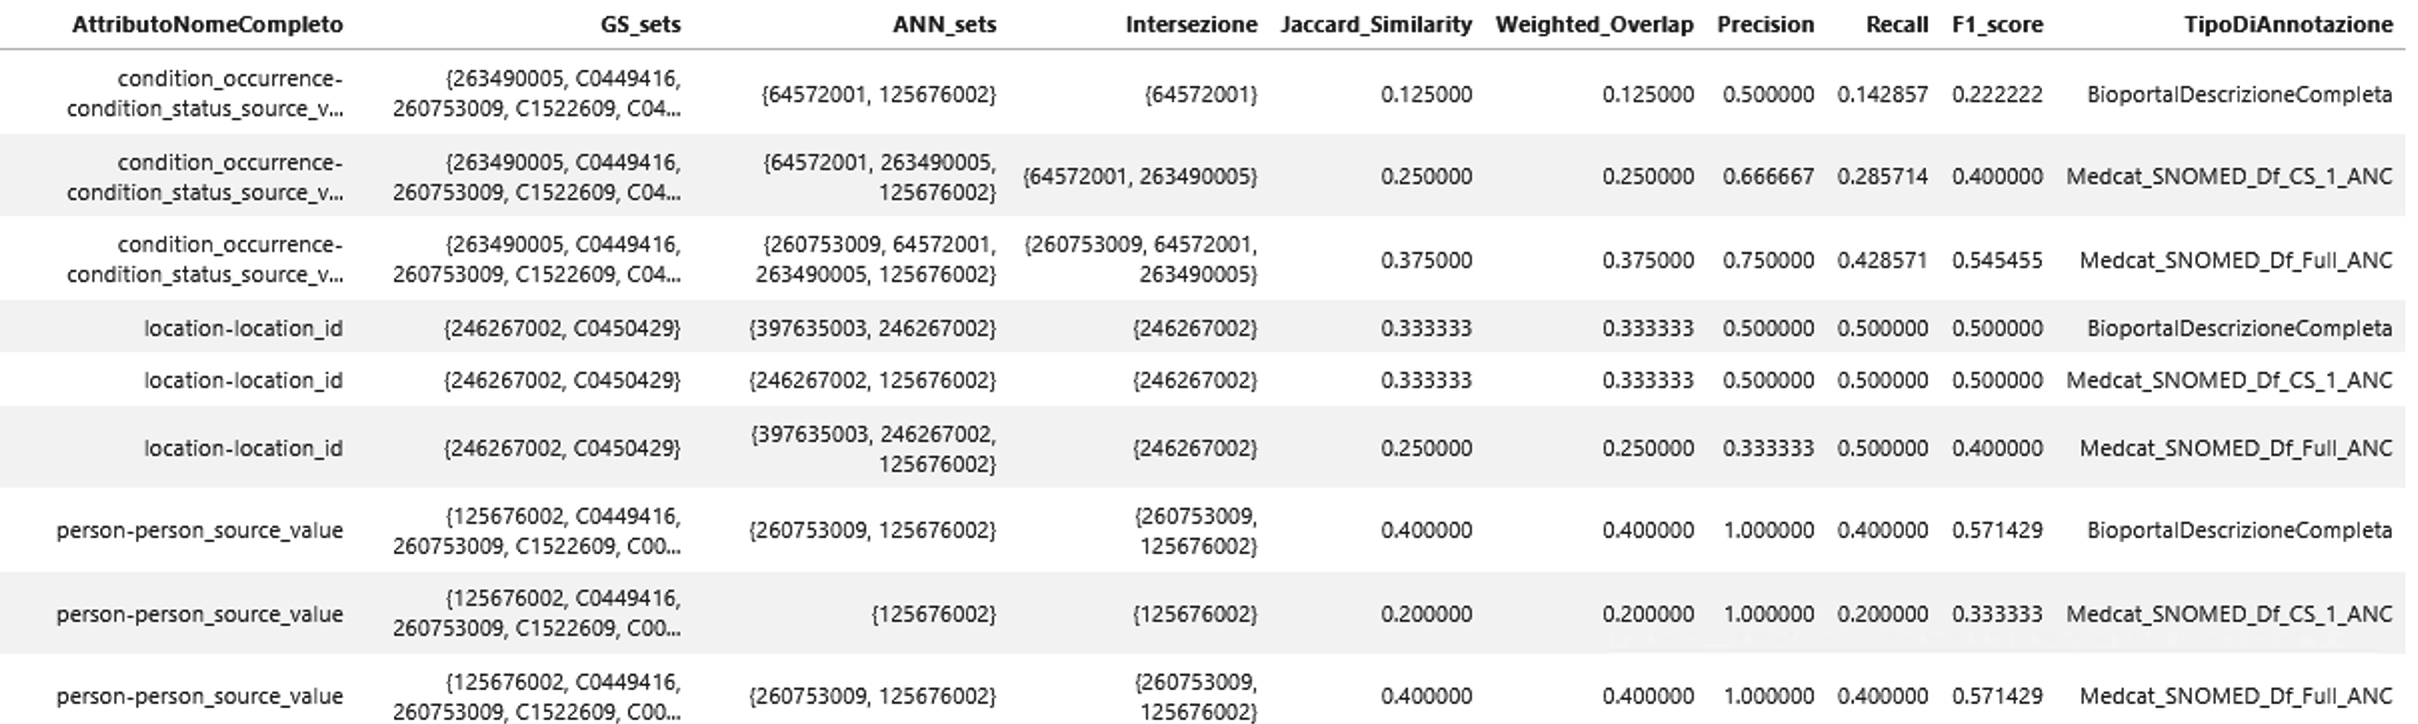




Per questi tre attributi

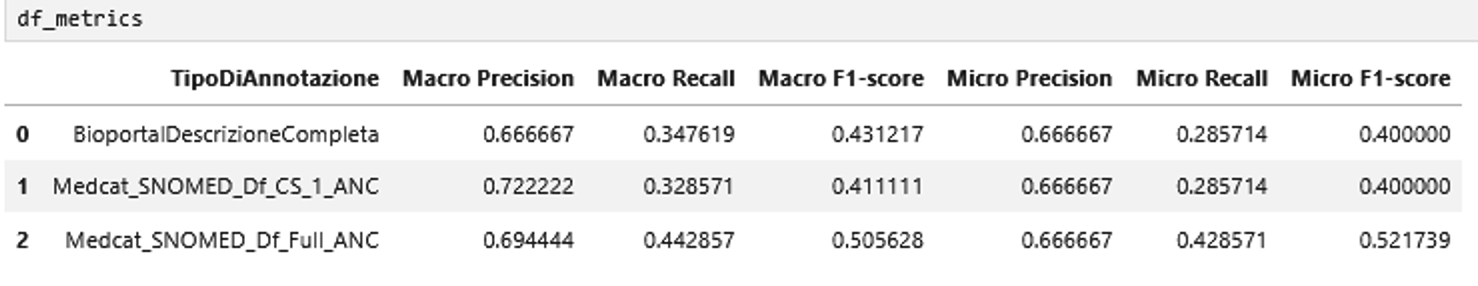

In [13]:
# QUESTA PARTE SERVE SOLO PER TROVARE TRE attributi che hanno annotazioni per tutte e tre i tipi e quindi valori significativi
# Filtra le righe con tre tipi
filtered = annotazioni_both[annotazioni_both['TipoDiAnnotazione'].isin(['Medcat_SNOMED_Df_Full_ANC',  'Medcat_SNOMED_Df_CS_1_ANC', 'BioportalDescrizioneCompleta'])]
# Trova gli attributi che appaiono con entrambi i valori richiesti
common_attributes = filtered.groupby('AttributoNomeCompleto')['TipoDiAnnotazione'].nunique()
valid_attributes = common_attributes[common_attributes == 3].index.tolist()

#filtered=filtered[filtered['AttributoNomeCompleto'].isin(valid_attributes[:3])]
##### NON FUNZIONA BENE PER PRENDERE ESEMPI SIGNIFICATIVI CON DIVERSE ANNOTAZIONI
# dopo alcune prove li scelgo a mano
#filtered=filtered[filtered['AttributoNomeCompleto'].isin(['person-person_source_value', 'person-location_id', 'location-county'])]
filtered=filtered[filtered['AttributoNomeCompleto'].isin(['person-person_source_value',
'condition_occurrence-condition_status_source_value','location-location_id', 
                                                         # 'person-location_id', 'location-county'
                                                         ])]
    
                                  

filtered[['Cui']].drop_duplicates()

,Cui
6374,125676002
7765,64572001
7772,263490005
7863,246267002
11388,260753009
13340,397635003


In [14]:
############## PER CONSIDERARE INVECE TUTTI GLI ATTRIBUTI

filtered = annotazioni_both
filtered[['Cui']].drop_duplicates()

,Cui
1281,125676002
1286,260753009
1304,263495000
1317,184099003
1332,258706009
1413,246267002
1415,397635003
2732,64572001
2947,263490005
3093,398070004


In [15]:
# Dizionario per salvare i risultati per ogni tipo di annotazione
df_results_per_type = {}

# Lista dei tipi di annotazione
tipi_di_annotazione = [
    'BioportalDescrizioneCompleta',
    'Medcat_SNOMED_Df_CS_1_ANC',
    'Medcat_SNOMED_Df_Full_ANC'
]

for tipo in tipi_di_annotazione:
    # Filtra solo le righe con il TipoDiAnnotazione corrente
    Xannotazioni_both = annotazioni_both[annotazioni_both['TipoDiAnnotazione'] == tipo]

    # Filtra solo gli attributi validi
    Xannotazioni_both = Xannotazioni_both[Xannotazioni_both['AttributoNomeCompleto'].isin(valid_attributes)]

    # Ottieni gli attributi unici rimasti
    attributi_filtered = Xannotazioni_both[['AttributoNomeCompleto']].drop_duplicates()

    # Crea i dizionari per GS e ANN solo per gli attributi filtrati
    GS_sets = GS_both.groupby('AttributoNomeCompleto')['Cui'].apply(set).reindex(attributi_filtered['AttributoNomeCompleto'], fill_value=set())
    ANN_sets = Xannotazioni_both.groupby('AttributoNomeCompleto')['Cui'].apply(set).reindex(attributi_filtered['AttributoNomeCompleto'], fill_value=set())

    # Creiamo il DataFrame per questo tipo di annotazione
    df_result_tipo = attributi_filtered.copy()
    df_result_tipo['GS_sets'] = df_result_tipo['AttributoNomeCompleto'].map(GS_sets)
    df_result_tipo['ANN_sets'] = df_result_tipo['AttributoNomeCompleto'].map(ANN_sets)

    # Salviamo il DataFrame nel dizionario con la chiave corrispondente al tipo di annotazione
    df_results_per_type[tipo] = df_result_tipo

# Ora puoi accedere ai risultati per ogni tipo di annotazione
df_results_per_type['BioportalDescrizioneCompleta']


,AttributoNomeCompleto,GS_sets,ANN_sets
33952,person-person_id,{},"{260753009, 125676002}"
33961,person-gender_concept_id,"{C0178566, C0079399, 263495000}","{260753009, 125676002}"
33970,person-year_of_birth,{},"{260753009, 125676002}"
33979,person-month_of_birth,"{258706009, C0439231}","{260753009, 125676002}"
33988,person-day_of_birth,"{258703001, C0439228}","{260753009, 125676002}"
34015,person-race_concept_id,"{C0034510, C0178566}","{260753009, 125676002}"
34024,person-ethnicity_concept_id,"{C0015031, C0178566}","{260753009, 125676002}"
34033,person-location_id,"{C0450429, 246267002}","{260753009, 125676002}"
34042,person-provider_id,{C1138603},"{260753009, 125676002}"
34051,person-care_site_id,{},"{260753009, 125676002}"


In [16]:
import numpy as np

# Lista dei tipi di annotazione
tipi_di_annotazione = [
    'BioportalDescrizioneCompleta',
    'Medcat_SNOMED_Df_CS_1_ANC',
    'Medcat_SNOMED_Df_Full_ANC'
]

# Lista per raccogliere i DataFrame elaborati
df_list = []

for tipo in tipi_di_annotazione:
    X = df_results_per_type[tipo].copy()
    
    # Calcoliamo l'intersezione
    X['Intersezione'] = X.apply(lambda row: row['GS_sets'] & row['ANN_sets'], axis=1)
    
    # Calcoliamo la Jaccard Similarity
    X['Jaccard_Similarity'] = X.apply(
        lambda row: len(row['Intersezione']) / len(row['GS_sets'] | row['ANN_sets']) if row['GS_sets'] | row['ANN_sets'] else np.nan,
        axis=1
    )
    
    # Placeholder per il Weighted Overlap (sostituire con pesi reali se disponibili)
    X['Weighted_Overlap'] = X['Jaccard_Similarity']  # Se non hai pesi, puoi usare Jaccard come proxy

    # Calcoliamo Precision, Recall e F1-score
    X['Precision'] = X.apply(
        lambda row: len(row['Intersezione']) / len(row['ANN_sets']) if len(row['ANN_sets']) > 0 else np.nan,
        axis=1
    )

    X['Recall'] = X.apply(
        lambda row: len(row['Intersezione']) / len(row['GS_sets']) if len(row['GS_sets']) > 0 else np.nan,
        axis=1
    )

    X['F1_score'] = X.apply(
        lambda row: 2 * (row['Precision'] * row['Recall']) / (row['Precision'] + row['Recall'])
        if (row['Precision'] + row['Recall']) > 0 else np.nan,
        axis=1
    )

    # Aggiungiamo la colonna con il tipo di annotazione
    X['TipoDiAnnotazione'] = tipo

    # Aggiungiamo il DataFrame elaborato alla lista
    df_list.append(X)

# Concatenazione dei DataFrame in un unico DataFrame finale
df_final = pd.concat(df_list, ignore_index=True)

df_final.sort_values('F1_score', ascending=False).head(3)

,AttributoNomeCompleto,GS_sets,ANN_sets,Intersezione,Jaccard_Similarity,Weighted_Overlap,Precision,Recall,F1_score,TipoDiAnnotazione
10,person-person_source_value,"{125676002, C0449416, C1522609, C0027361, 2607...","{260753009, 125676002}","{260753009, 125676002}",0.4,0.4,1.000000,0.4,0.571429,BioportalDescrizioneCompleta
104,condition_occurrence-condition_end_date,"{410671006, C0012634, 64572001, C0011008}","{410671006, 64572001, 125676002}","{410671006, 64572001}",0.4,0.4,0.666667,0.5,0.571429,Medcat_SNOMED_Df_Full_ANC
92,person-person_source_value,"{125676002, C0449416, C1522609, C0027361, 2607...","{260753009, 125676002}","{260753009, 125676002}",0.4,0.4,1.000000,0.4,0.571429,Medcat_SNOMED_Df_Full_ANC


In [17]:

# Selezioniamo i primi 5 attributi per ogni TipoDiAnnotazione ordinati per F1_score

top_5_per_tipo = (
    df_final.groupby('TipoDiAnnotazione')
    .apply(lambda group: group.nlargest(5, 'F1_score')[df_final.columns])
    .reset_index(drop=True)
)

# Visualizziamo il risultato
top_5_per_tipo.sort_values('AttributoNomeCompleto')
#                          

C:\Users\gabry\AppData\Local\Temp\ipykernel_26840\4150067619.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.nlargest(5, 'F1_score')[df_final.columns])


,AttributoNomeCompleto,GS_sets,ANN_sets,Intersezione,Jaccard_Similarity,Weighted_Overlap,Precision,Recall,F1_score,TipoDiAnnotazione
8,condition_occurrence-condition_concept_id,"{C0012634, 64572001, C0178566}","{64572001, 125676002}",{64572001},0.250000,0.250000,0.500000,0.333333,0.400000,Medcat_SNOMED_Df_CS_1_ANC
12,condition_occurrence-condition_end_date,"{410671006, C0012634, 64572001, C0011008}","{410671006, 64572001, 125676002}","{410671006, 64572001}",0.400000,0.400000,0.666667,0.500000,0.571429,Medcat_SNOMED_Df_Full_ANC
11,condition_occurrence-condition_start_date,"{410671006, C0012634, 64572001, C0011008}","{410671006, 64572001, 125676002}","{410671006, 64572001}",0.400000,0.400000,0.666667,0.500000,0.571429,Medcat_SNOMED_Df_Full_ANC
9,condition_occurrence-condition_status_source_v...,"{C0449416, C0449438, 263490005, C1522609, C001...","{263490005, 64572001, 125676002}","{263490005, 64572001}",0.250000,0.250000,0.666667,0.285714,0.400000,Medcat_SNOMED_Df_CS_1_ANC
13,condition_occurrence-condition_status_source_v...,"{C0449416, C0449438, 263490005, C1522609, C001...","{263490005, 64572001, 125676002, 260753009}","{263490005, 64572001, 260753009}",0.375000,0.375000,0.750000,0.428571,0.545455,Medcat_SNOMED_Df_Full_ANC
2,location-address_1,"{397635003, C1442065}","{246267002, 397635003}",{397635003},0.333333,0.333333,0.500000,0.500000,0.500000,BioportalDescrizioneCompleta
3,location-address_2,"{397635003, C1442065}","{246267002, 397635003}",{397635003},0.333333,0.333333,0.500000,0.500000,0.500000,BioportalDescrizioneCompleta
4,location-county,"{397635003, C1442065}","{246267002, 397635003}",{397635003},0.333333,0.333333,0.500000,0.500000,0.500000,BioportalDescrizioneCompleta
1,location-location_id,"{C0450429, 246267002}","{246267002, 397635003}",{246267002},0.333333,0.333333,0.500000,0.500000,0.500000,BioportalDescrizioneCompleta
6,location-location_id,"{C0450429, 246267002}","{125676002, 246267002}",{246267002},0.333333,0.333333,0.500000,0.500000,0.500000,Medcat_SNOMED_Df_CS_1_ANC


In [18]:
# Lista per raccogliere i risultati
results = []

# Iteriamo su ogni tipo di annotazione
for tipo in df_final['TipoDiAnnotazione'].unique():
    X = df_final[df_final['TipoDiAnnotazione'] == tipo]
    
    # Aggregazione Macro-average
    precision_macro = X['Precision'].mean()
    recall_macro = X['Recall'].mean()
    f1_macro = X['F1_score'].mean()

    # Aggregazione Micro-average
    total_tp = X['Intersezione'].apply(len).sum()
    total_ann = X['ANN_sets'].apply(len).sum()
    total_gs = X['GS_sets'].apply(len).sum()

    precision_micro = total_tp / total_ann if total_ann > 0 else np.nan
    recall_micro = total_tp / total_gs if total_gs > 0 else np.nan
    f1_micro = (
        2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)
        if (precision_micro + recall_micro) > 0 else np.nan
    )

    # Aggiungiamo i risultati alla lista
    results.append([tipo, precision_macro, recall_macro, f1_macro, precision_micro, recall_micro, f1_micro])

# Creiamo il DataFrame finale
columns = ['TipoDiAnnotazione', 'Macro Precision', 'Macro Recall', 'Macro F1-score', 
           'Micro Precision', 'Micro Recall', 'Micro F1-score']
df_metrics = pd.DataFrame(results, columns=columns)

# Visualizziamo il risultato
df_metrics

,TipoDiAnnotazione,Macro Precision,Macro Recall,Macro F1-score,Micro Precision,Micro Recall,Micro F1-score
0,BioportalDescrizioneCompleta,0.341463,0.205663,0.354703,0.341463,0.213740,0.262911
1,Medcat_SNOMED_Df_CS_1_ANC,0.256098,0.141055,0.336786,0.283784,0.160305,0.204878
2,Medcat_SNOMED_Df_Full_ANC,0.351220,0.303475,0.396013,0.362069,0.320611,0.340081


In [24]:
# indicativamente sembrano significativi
# la recal di MedCat Full è maggiore delle altre
# la recoll di 1 è inferiore perchè prendi pochi elementi
# bioportal sembra avere valori confrontabili con MedCat full

In [ ]:
#



###  Jaccard vs Precision/Recall/F1

Finora abbiamo usato Precision/Recall/F1

Se e a cosa serve la Jaccard


- **Jaccard** misura la sovrapposizione generale tra due insiemi.  
- **Precision, Recall e F1-score** valutano l’accuratezza dell’annotatore

vediamo la correlazione

**Caso in cui Recall = 1**

Quando la Recall è 1, significa che ANN ha trovato tutti gli elementi di GS.  
Quindi:
$
|GS \cap ANN| = |GS|
$

Ma sappiamo anche che:
$
|GS \cup ANN| = |GS| + |ANN| - |GS \cap ANN|
$

Sostituendo \( |GS \cap ANN| = |GS| \), otteniamo:
$
|GS \cup ANN| = |GS| + |ANN| - |GS| = |ANN|
$

Quindi:
$
Jaccard = \frac{|GS \cap ANN|}{|GS \cup ANN|} = \frac{|GS|}{|ANN|} = Precision
$

Quindi, se \( Recall = 1 \), la **Jaccard Similarity** è uguale alla **Precision** perché ANN contiene tutto GS, e quindi l’unione \( |GS \cup ANN| \) è semplicemente \( |ANN| \).  

**Caso in cui Recall < 1**

Quando **Recall è inferiore a 1**, significa che ANN ha perso alcuni elementi di GS.  
Quindi \( |GS \cap ANN| < |GS| \), e di conseguenza l’unione \( |GS \cup ANN| \) aumenta:
$
|GS \cup ANN| > |ANN|
$
Poiché il denominatore della **Jaccard** aumenta rispetto alla **Precision**, si ha che:
$
Jaccard < Precision
$


In [19]:
#dettagliare questa analisi rispetto alle diverse annotazioni --- QUESTO LO VERIFICHIAMO DOPO
# Aggiungiamo un annotatore fittizio per GS
GS['Annotator'] = 'Gold_Standard'

# Cambiamo il nome della colonna 'source' in 'Provenienza'
GS['Provenienza'] = 'GS'
annotazioni['Provenienza'] = 'annotazioni'
df_combined = pd.concat([GS, annotazioni])

# Raggruppiamo per Ontology e Annotator
ontology_annotator_counts = df_combined.groupby(['Ontologies', 'Annotator', 'Provenienza']).size().unstack(fill_value=0)

# Rinominiamo le colonne
ontology_annotator_counts.columns = ['Nleft', 'Nright']
ontology_annotator_counts['Nboth'] = ontology_annotator_counts.min(axis=1)

# Output finale
print(ontology_annotator_counts)

                          Nleft  Nright  Nboth
Ontologies Annotator                          
LOINC      Bioportal          0    7903      0
SNOMED-CT  Bioportal          0    4791      0
           Gold_Standard    127       0      0
           MedCAT             0   15607      0
UMLS       Gold_Standard    196       0      0
           MedCAT             0    9801      0


In [26]:
GS.columns

Index(['TipoDiAnnotazione', 'Ontologies', 'Source', 'AttributoNomeCompleto',
       'EntityID', 'PrettyName', 'Cui', 'Annotator', 'Provenienza'],
      dtype='object')

# Valutazione della Qualità degli Annotatori

## Metriche di valutazione

In [38]:
def evaluate_annotation(gs_df, ann_df, column):

    gs = set(gs_df[column].dropna())
    ann = set(ann_df[column].dropna())

    true_positives = len(gs & ann)  # Elementi corretti
    precision = true_positives / len(ann) if len(ann) > 0 else 0
    recall = true_positives / len(gs) if len(gs) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-score": round(f1_score, 4)
    }

# Esempio di utilizzo


metrics = evaluate_annotation(GS, annotazioni, "AttributoNomeCompleto")
print(metrics)

{'Precision': 0.0576, 'Recall': 0.5541, 'F1-score': 0.1043}


In [67]:
def evaluate_macro_micro(gs_df, ann_df, columns):
    import pandas as pd

    def normalize(val):
        # converte stringhe separate da virgola in set di valori puliti e lowercase
        if pd.isna(val):
            return set()
        return set(v.strip().lower() for v in str(val).split(",") if v.strip())

    macro_precisions = []
    macro_recalls = []
    macro_f1s = []

    micro_tp = 0
    micro_ann_total = 0
    micro_gs_total = 0

    for col in columns:
        col_tp = 0
        col_ann_total = 0
        col_gs_total = 0

        for i in range(len(gs_df)):
            gs = normalize(gs_df.iloc[i][col])
            ann = normalize(ann_df.iloc[i][col])

            tp = len(gs & ann)
            ann_total = len(ann)
            gs_total = len(gs)

            col_tp += tp
            col_ann_total += ann_total
            col_gs_total += gs_total

        # Precision, recall, f1 per attributo (colonna)
        precision = col_tp / col_ann_total if col_ann_total > 0 else 0
        recall = col_tp / col_gs_total if col_gs_total > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        macro_precisions.append(precision)
        macro_recalls.append(recall)
        macro_f1s.append(f1)

        # accumulo per micro
        micro_tp += col_tp
        micro_ann_total += col_ann_total
        micro_gs_total += col_gs_total

    # Macro-average (media semplice sulle colonne)
    precision_macro = sum(macro_precisions) / len(columns) if columns else 0
    recall_macro = sum(macro_recalls) / len(columns) if columns else 0
    f1_macro = sum(macro_f1s) / len(columns) if columns else 0

    # Micro-average (totale veri positivi su totale annotazioni e ground truth)
    precision_micro = micro_tp / micro_ann_total if micro_ann_total > 0 else 0
    recall_micro = micro_tp / micro_gs_total if micro_gs_total > 0 else 0
    f1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro) if (precision_micro + recall_micro) > 0 else 0

    return {
        "Macro Precision": round(precision_macro, 4),
        "Macro Recall": round(recall_macro, 4),
        "Macro F1-score": round(f1_macro, 4),
        "Micro Precision": round(precision_micro, 4),
        "Micro Recall": round(recall_micro, 4),
        "Micro F1-score": round(f1_micro, 4)
    }




# DOMANDA

però in questo modo confronto tutti gli elementi del gs  con tutti gli elementi dell'annotazioni,
*indipendentemente dagli attributi ai quali sono associati*

vediamo cosa succede con i tre attributi di sopra

In [68]:
GS_filtered=GS[GS['AttributoNomeCompleto'].isin(['person-person_source_value',
'condition_occurrence-condition_status_source_value','location-location_id', 
                                                         # 'person-location_id', 'location-county'
                                                         ])]

annotazioni_filtered=annotazioni[annotazioni['AttributoNomeCompleto'].isin(['person-person_source_value',
'condition_occurrence-condition_status_source_value','location-location_id', 
                                                         # 'person-location_id', 'location-county'
                                                         ])]

In [53]:
evaluate_annotation(GS_filtered, annotazioni_filtered, "AttributoNomeCompleto")

{'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0}

In [70]:
evaluate_macro_micro(GS_filtered, annotazioni_filtered, ["AttributoNomeCompleto"])

{'Macro Precision': 0.1875,
 'Macro Recall': 0.1875,
 'Macro F1-score': 0.1875,
 'Micro Precision': 0.1875,
 'Micro Recall': 0.1875,
 'Micro F1-score': 0.1875}

non tengo conto del confronto attributo per attributo (oltre al fatto di considerare tutti assieme tutti i tipi di annotazione)
quindi del fatto che che ad ogni attributo il GS associa un certo insieme di attributi e un tipo di annotazione un altro
come appunto in questo esempio di riferimento (ricordo che era riferito ad un particolare TipoDiAnnotazione)

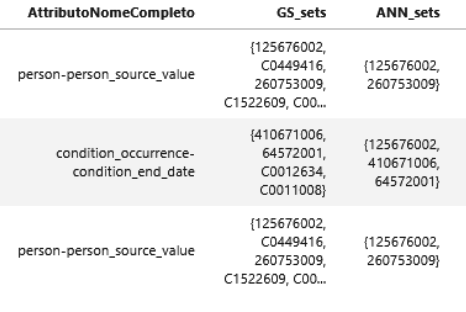



prova a rivedere tutto il discorso fatto fin qui, poi si prosegue con il resto


un'altra prova che si potrebbe fare: fare l'unione (o l'intersezione) delle annotazioni prodotte dai vari tipi di annotazione
e verificare come cambiano i risultati

### UNIONE E INTERSEZIONE TRA DATABASE MEDCAT E BIOPORTAL

In [56]:
annotazioni.columns

Index(['TipoDiAnnotazione', 'Ontologies', 'Source', 'AttributoNomeCompleto',
       'EntityID', 'PrettyName', 'Cui', 'Annotator', 'Provenienza'],
      dtype='object')

In [57]:
def filtra_annotazioni(df, Sistema):
    # Mappatura colonne
    col_A = 'AttributoNomeCompleto'
    col_VOC = 'Ontologies'
    col_C = 'Cui'
    col_i = 'EntityID'
    col_SISTEMA = 'Annotator'

    # Normalizza annotator in maiuscolo per confronto
    df = df.copy()
    df[col_SISTEMA] = df[col_SISTEMA].str.upper()

    if Sistema == 'M':
        return df[df[col_SISTEMA] == 'MEDCAT'].copy()

    elif Sistema == 'B':
        return df[df[col_SISTEMA] == 'BIOPORTAL'].copy()

    elif Sistema == 'B_AND_M':
        medcat_triples = set(df[df[col_SISTEMA] == 'MEDCAT'][[col_A, col_VOC, col_C]].apply(tuple, axis=1))
        bioportal_triples = set(df[df[col_SISTEMA] == 'BIOPORTAL'][[col_A, col_VOC, col_C]].apply(tuple, axis=1))
        comuni = medcat_triples & bioportal_triples

        df_comuni = df[df.apply(lambda row: (row[col_A], row[col_VOC], row[col_C]) in comuni, axis=1)].copy()
        df_comuni[col_SISTEMA] = 'MEDCAT_AND_BIOPORTAL'
        return df_comuni

    elif Sistema == 'B_OR_M':
        medcat = df[df[col_SISTEMA] == 'MEDCAT']
        bioportal = df[df[col_SISTEMA] == 'BIOPORTAL']

        medcat_triples = set(medcat[[col_A, col_VOC, col_C]].apply(tuple, axis=1))
        bioportal_triples = set(bioportal[[col_A, col_VOC, col_C]].apply(tuple, axis=1))
        comuni = medcat_triples & bioportal_triples

        comuni_df = df[df.apply(
            lambda row: (row[col_A], row[col_VOC], row[col_C]) in comuni and row[col_SISTEMA] in ['MEDCAT', 'BIOPORTAL'],
            axis=1
        )]

        nuovi = comuni_df.copy()
        nuovi[col_SISTEMA] = 'BIOPORTAL_OR_MEDCAT'

        df_filtrato = df[~df.apply(
            lambda row: (row[col_A], row[col_VOC], row[col_C]) in comuni and row[col_SISTEMA] in ['MEDCAT', 'BIOPORTAL'],
            axis=1
        )]

        df_finale = pd.concat([df_filtrato, nuovi], ignore_index=True).sort_values(by=[col_A, col_i]).reset_index(drop=True)
        return df_finale

    else:
        raise ValueError("Parametro Sistema non valido. Usa 'M', 'B', 'B_AND_M' o 'B_OR_M'.")


In [58]:
unione = filtra_annotazioni(annotazioni, 'B_AND_M')
unione.head(5)

,TipoDiAnnotazione,Ontologies,Source,AttributoNomeCompleto,EntityID,PrettyName,Cui,Annotator,Provenienza
1281,Medcat_SNOMED_Df_CS_08_ANC,SNOMED-CT,OMOP,person-person_id,0,Person,125676002,MEDCAT_AND_BIOPORTAL,annotazioni
1282,Medcat_SNOMED_Df_CS_08_ANC,SNOMED-CT,OMOP,person-person_id,1,Concept model domain,609431004,MEDCAT_AND_BIOPORTAL,annotazioni
1285,Medcat_SNOMED_Df_CS_08_ANC,SNOMED-CT,OMOP,person-person_id,4,Patient,116154003,MEDCAT_AND_BIOPORTAL,annotazioni
1286,Medcat_SNOMED_Df_CS_08_ANC,SNOMED-CT,OMOP,person-person_id,5,Source,260753009,MEDCAT_AND_BIOPORTAL,annotazioni
1288,Medcat_SNOMED_Df_CS_08_ANC,SNOMED-CT,OMOP,person-person_id,9,Clinical,58147004,MEDCAT_AND_BIOPORTAL,annotazioni


In [71]:
evaluate_annotation(GS, annotazioni, 'AttributoNomeCompleto')

{'Precision': 0.0576, 'Recall': 0.5541, 'F1-score': 0.1043}

In [73]:
evaluate_macro_micro(GS, annotazioni, ['AttributoNomeCompleto'])

{'Macro Precision': 0.0,
 'Macro Recall': 0.0,
 'Macro F1-score': 0.0,
 'Micro Precision': 0.0,
 'Micro Recall': 0.0,
 'Micro F1-score': 0}

In [74]:
evaluate_macro_micro(GS, annotazioni, ['TipoDiAnnotazione', 'Ontologies', 'Source', 'AttributoNomeCompleto',
       'EntityID', 'PrettyName', 'Cui', 'Annotator', 'Provenienza'])

{'Macro Precision': 0.0619,
 'Macro Recall': 0.0619,
 'Macro F1-score': 0.0619,
 'Micro Precision': 0.0616,
 'Micro Recall': 0.0619,
 'Micro F1-score': 0.0617}

In [61]:
evaluate_annotation(GS, unione, 'AttributoNomeCompleto')

{'Precision': 0.1536, 'Recall': 0.5541, 'F1-score': 0.2405}

In [62]:
evaluate_macro_micro(GS, unione, ['AttributoNomeCompleto'])

{'Macro Precision': 0.0,
 'Macro Recall': 0.0,
 'Macro F1-score': 0.0,
 'Micro Precision': 0.0,
 'Micro Recall': 0.0,
 'Micro F1-score': 0}

In [75]:
evaluate_macro_micro(GS, unione, ['TipoDiAnnotazione', 'Ontologies', 'Source', 'AttributoNomeCompleto',
       'EntityID', 'PrettyName', 'Cui', 'Annotator', 'Provenienza'])

{'Macro Precision': 0.1629,
 'Macro Recall': 0.1631,
 'Macro F1-score': 0.163,
 'Micro Precision': 0.1618,
 'Micro Recall': 0.1631,
 'Micro F1-score': 0.1624}

analizzando le due valutazioni, si riscontra come ci sia un aumento della precision e dell' f1 score e recall uguale

In [63]:
intersezione = filtra_annotazioni(annotazioni, 'B_OR_M')
intersezione.head(5)

,TipoDiAnnotazione,Ontologies,Source,AttributoNomeCompleto,EntityID,PrettyName,Cui,Annotator,Provenienza
0,Medcat_SNOMED_Df_CS_08_ANC,SNOMED-CT,Mimic,admissions-admission_location,0,Hospital admission,32485007,MEDCAT,annotazioni
1,Medcat_SNOMED_Df_CS_1_ANC,SNOMED-CT,Mimic,admissions-admission_location,0,Hospital admission,32485007,MEDCAT,annotazioni
2,Medcat_SNOMED_Df_Full_ANC,SNOMED-CT,Mimic,admissions-admission_location,0,Hospital admission,32485007,MEDCAT,annotazioni
3,Medcat_UMLS_Df_Full_ANC,UMLS,Mimic,admissions-admission_location,0,"Admission, Patient",C0030673,MEDCAT,annotazioni
4,Medcat_SNOMED_Df_CS_08_ANC,SNOMED-CT,Mimic,admissions-admission_location,1,"Table, device",86407004,MEDCAT,annotazioni


In [64]:
evaluate_annotation(GS, intersezione, 'AttributoNomeCompleto')

{'Precision': 0.0576, 'Recall': 0.5541, 'F1-score': 0.1043}

In [76]:
evaluate_macro_micro(GS, intersezione, ['AttributoNomeCompleto'])

{'Macro Precision': 0.0,
 'Macro Recall': 0.0,
 'Macro F1-score': 0.0,
 'Micro Precision': 0.0,
 'Micro Recall': 0.0,
 'Micro F1-score': 0}

In [77]:
evaluate_macro_micro(GS, intersezione, ['TipoDiAnnotazione', 'Ontologies', 'Source', 'AttributoNomeCompleto',
       'EntityID', 'PrettyName', 'Cui', 'Annotator', 'Provenienza'])

{'Macro Precision': 0.0556,
 'Macro Recall': 0.0557,
 'Macro F1-score': 0.0557,
 'Micro Precision': 0.0549,
 'Micro Recall': 0.0557,
 'Micro F1-score': 0.0553}

## Metodi di confronto

In [17]:
def metodi_confronto(gs_df, ann_df, column):

    gs = set(gs_df[column].dropna())
    ann = set(ann_df[column].dropna())

    intersection = gs & ann  # Concetti comuni

    # Jaccard Similarity
    jaccard = len(intersection) / len(gs | ann) if len(gs | ann) > 0 else 0

    # Weighted Overlap
    weighted_overlap = sum(1 for concept in intersection) / sum(1 for concept in gs) if len(gs) > 0 else 0

    return {
        "Intersection": len(intersection),
        "Jaccard Similarity": round(jaccard, 4),
        "Weighted Overlap": round(weighted_overlap, 4),
        "Valori dell'intersezione": intersection
    }



metrics = metodi_confronto(GS, annotazioni, "AttributoNomeCompleto")
print(metrics)

{'Jaccard Similarity': 0.055, 'Weighted Overlap': 0.5541, 'Intersection': 41, "Valori dell'intersezione": {'person-gender_source_concept_id', 'condition_occurrence-provider_id', 'condition_occurrence-condition_source_concept_id', 'person-ethnicity_source_value', 'condition_occurrence-condition_type_concept_id', 'location-zip', 'location-address_1', 'condition_occurrence-condition_status_source_value', 'person-year_of_birth', 'location-address_2', 'condition_occurrence-stop_reason', 'person-race_source_concept_id', 'person-gender_source_value', 'condition_occurrence-person_id', 'location-county', 'person-person_id', 'condition_occurrence-condition_concept_id', 'location-city', 'person-ethnicity_concept_id', 'person-month_of_birth', 'location-location_id', 'location-state', 'location-location_source_value', 'condition_occurrence-condition_occurrence_id', 'person-ethnicity_source_concept_id', 'condition_occurrence-visit_detail_id', 'person-race_source_value', 'condition_occurrence-conditi

In [27]:
gs_df = GS.assign(source='GS')
# Calcoliamo la frequenza d'uso dei concetti nel Gold Standard
gs_freq = gs_df['AttributoNomeCompleto'].value_counts()


# Mappiamo la frequenza come peso nei concetti di GS
gs_df['Peso'] = gs_df['AttributoNomeCompleto'].map(gs_freq)


# Uniamo i due DataFrame per ottenere i concetti comuni
merged_df = pd.merge(gs_df, annotazioni, on='AttributoNomeCompleto', how='inner')

# Calcoliamo l'overlap ponderato sommando i pesi dei concetti comuni
overlap_ponderato = (merged_df['Peso'] * gs_freq[merged_df['AttributoNomeCompleto']]).sum()

print(f'Overlap Ponderato: {overlap_ponderato}')


Overlap Ponderato: 0.0


NON CAPISCO PERCHÈ L'OVERLAP PONDERATO SIA UGUALE A 0

In [29]:
#Troviamo l'intersezione tra Gold Standard e Annotazioni
common_concepts = set(GS['AttributoNomeCompleto']).intersection(set(annotazioni['AttributoNomeCompleto']))

# 3. Calcoliamo la percentuale di concetti del Gold Standard presenti nelle Annotazioni
total_concepts_gs = len(GS)
correctly_annotated = len(common_concepts)

# Percentuale di concetti correttamente annotati
annotation_accuracy = (correctly_annotated / total_concepts_gs) * 100

# 4. Valutiamo la bontà degli annotatori
print(f'Concetti totali nel Gold Standard: {total_concepts_gs}')
print(f'Concetti correttamente annotati: {correctly_annotated}')
print(f'Accuratezza delle annotazioni: {annotation_accuracy:.2f}%')

Concetti totali nel Gold Standard: 323
Concetti correttamente annotati: 41
Accuratezza delle annotazioni: 12.69%


## Calcolo metriche su più attributi

In [32]:
def calculate_metrics(gs_df, ann_df):
    # Inizializziamo un dizionario per memorizzare i risultati per ogni concetto
    metrics = {'AttributoNomeCompleto': [], 'Precision': [], 'Recall': [], 'F1': []}

    # Elenco dei concetti unici presenti nel GS
    all_concepts = gs_df['AttributoNomeCompleto'].unique()

    for concept in all_concepts:
        # Filtra i concetti corrispondenti nel GS e nelle Annotazioni
        gs_concepts = set(gs_df[gs_df['AttributoNomeCompleto'] == concept]['AttributoNomeCompleto'])
        ann_concepts = set(ann_df[ann_df['AttributoNomeCompleto'] == concept]['AttributoNomeCompleto'])

        # Calcolo della Precision
        precision = len(gs_concepts.intersection(ann_concepts)) / len(ann_concepts) if len(ann_concepts) > 0 else 0

        # Calcolo del Recall
        recall = len(gs_concepts.intersection(ann_concepts)) / len(gs_concepts) if len(gs_concepts) > 0 else 0

        # Calcolo del F1-Score
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Memorizza i risultati per ogni concetto
        metrics['AttributoNomeCompleto'].append(concept)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1'].append(f1)

    # Convertiamo in DataFrame per una migliore visualizzazione
    metrics_df = pd.DataFrame(metrics)

    return metrics_df

def calculate_aggregated_metrics(metrics_df):
    # Macro-average: media delle metriche
    precision_macro = metrics_df['Precision'].mean()
    recall_macro = metrics_df['Recall'].mean()
    f1_macro = metrics_df['F1'].mean()

    # Micro-average: somma dei veri positivi, falsi positivi e falsi negativi
    total_tp = sum([metrics_df.iloc[i]['Precision'] * metrics_df.iloc[i]['Recall'] for i in range(len(metrics_df))])
    total_fp = sum([metrics_df.iloc[i]['Precision'] * (1 - metrics_df.iloc[i]['Recall']) for i in range(len(metrics_df))])
    total_fn = sum([metrics_df.iloc[i]['Recall'] * (1 - metrics_df.iloc[i]['Precision']) for i in range(len(metrics_df))])

    precision_micro = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall_micro = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_micro = (2 * precision_micro * recall_micro) / (precision_micro + recall_micro) if (precision_micro + recall_micro) > 0 else 0

    # Restituisce le metriche aggregate
    aggregated_metrics = {
        'Precisionmacro': precision_macro,
        'Recallmacro': recall_macro,
        'F1macro': f1_macro,
        'Precisionmicro': precision_micro,
        'Recallmicro': recall_micro,
        'F1micro': f1_micro
    }

    return aggregated_metrics

# Calcoliamo le metriche per ciascun concetto (AttributoNomeCompleto)
metrics_df = calculate_metrics(gs_df, annotazioni)

# Calcoliamo le metriche aggregate (Macro e Micro)
aggregated_metrics = calculate_aggregated_metrics(metrics_df)

# Visualizziamo le metriche aggregate
print("Metriche Aggregate:")
for metric, value in aggregated_metrics.items():
    print(f"{metric}: {value}")


Metriche Aggregate:
Precisionmacro: 0.5540540540540541
Recallmacro: 0.5540540540540541
F1macro: 0.5540540540540541
Precisionmicro: 1.0
Recallmicro: 1.0
F1micro: 1.0


## Analisi della Similarit`a tra Attributi con Annotazioni Diverse

In [35]:
import pandas as pd

# Funzione per calcolare l'intersezione tra due insiemi
def intersection(set1, set2):
    return len(set1.intersection(set2))

# Funzione per calcolare la similarità di Jaccard
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2)) if len(set1.union(set2)) > 0 else 0

# Funzione per calcolare il coefficiente di Sorensen-Dice
def sorensen_dice(set1, set2):
    return (2 * len(set1.intersection(set2))) / (len(set1) + len(set2)) if (len(set1) + len(set2)) > 0 else 0

# Funzione per calcolare la corrispondenza per ogni attributo
def calculate_similarity(gs_df, ann_df, threshold):
    similarity_results = {
        'AttributoNomeCompleto': [],
        'Jaccard': [],
        'Sorensen-Dice': [],
        'Corrispondenza': []
    }

    # Iteriamo su ciascun attributo
    for attribute in gs_df['AttributoNomeCompleto'].unique():
        # Prendiamo gli insiemi di annotazioni per l'attributo in entrambi gli schemi
        gs_annotations = set(gs_df[gs_df['AttributoNomeCompleto'] == attribute]['PrettyName'])
        ann_annotations = set(ann_df[ann_df['AttributoNomeCompleto'] == attribute]['PrettyName'])

        # Calcoliamo le metriche di similarità
        jaccard = jaccard_similarity(gs_annotations, ann_annotations)
        dice = sorensen_dice(gs_annotations, ann_annotations)

        # Verifica della corrispondenza (Jaccard)
        corrispondenza = 1 if jaccard >= threshold else 0

        # Aggiungiamo i risultati
        similarity_results['AttributoNomeCompleto'].append(attribute)
        similarity_results['Jaccard'].append(jaccard)
        similarity_results['Sorensen-Dice'].append(dice)
        similarity_results['Corrispondenza'].append(corrispondenza)

    # Creiamo un DataFrame con i risultati
    similarity_df = pd.DataFrame(similarity_results)

    return similarity_df



# Definiamo una soglia di similarità per la corrispondenza
threshold = 0.8

# Calcoliamo la similarità tra gli attributi
similarity_df = calculate_similarity(GS, annotazioni, threshold)

# Visualizziamo i risultati
print(similarity_df)


                 AttributoNomeCompleto   Jaccard  Sorensen-Dice  \
0                    location-location  0.000000       0.000000   
1                 location-location_id  0.043478       0.083333   
2                   location-address_1  0.040000       0.076923   
3                   location-address_2  0.038462       0.074074   
4                        location-city  0.080000       0.148148   
..                                 ...       ...            ...   
69     person-gender_source_concept_id  0.071429       0.133333   
70            person-race_source_value  0.081081       0.150000   
71       person-race_source_concept_id  0.034483       0.066667   
72       person-ethnicity_source_value  0.027027       0.052632   
73  person-ethnicity_source_concept_id  0.033333       0.064516   

    Corrispondenza  
0                0  
1                0  
2                0  
3                0  
4                0  
..             ...  
69               0  
70               0  
71    

## Valutazione della Corrispondenza con Precision, Recall e F1

In [37]:
# Funzioni per calcolare TP, FP e FN
def true_positives(gs_set, ann_set):
    return len(gs_set.intersection(ann_set))

def false_positives(gs_set, ann_set):
    return len(ann_set - gs_set)

def false_negatives(gs_set, ann_set):
    return len(gs_set - ann_set)

# Funzione per calcolare Precision, Recall e F1-Score
def calculate_metrics(gs_set, ann_set):
    tp = true_positives(gs_set, ann_set)
    fp = false_positives(gs_set, ann_set)
    fn = false_negatives(gs_set, ann_set)

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1

# Funzione per confrontare gli attributi e calcolare le metriche aggregate
def compare_attributes(gs_df, ann_df, threshold=0.5):
    comparison_results = {}

    for attribute in gs_df['AttributoNomeCompleto'].unique():
        # Estrai gli insiemi di annotazioni per l'attributo corrente
        gs_annotations = set(gs_df[gs_df['AttributoNomeCompleto'] == attribute]['PrettyName'])
        ann_annotations = set(ann_df[ann_df['AttributoNomeCompleto'] == attribute]['PrettyName'])

        # Calcolo delle metriche di Precision, Recall e F1-Score
        precision, recall, f1 = calculate_metrics(gs_annotations, ann_annotations)

        # Salva i risultati
        comparison_results[attribute] = {
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }

    return comparison_results

# Supponiamo che gs_df e ann_df siano i tuoi DataFrame contenenti i dati per GS e Annotator X
# gs_df = pd.read_csv('gold_standard.csv')
# ann_df = pd.read_csv('annotator.csv')

# Confrontiamo gli attributi
comparison_results = compare_attributes(GS, annotazioni)

# Visualizziamo i risultati
for attribute, metrics in comparison_results.items():
    print(f"Attributo: {attribute}")
    print(f"Precision: {metrics['Precision']}")
    print(f"Recall: {metrics['Recall']}")
    print(f"F1: {metrics['F1']}")
    print()

Attributo: location-location
Precision: 0
Recall: 0.0
F1: 0

Attributo: location-location_id
Precision: 0.045454545454545456
Recall: 0.5
F1: 0.08333333333333334

Attributo: location-address_1
Precision: 0.04
Recall: 1.0
F1: 0.07692307692307693

Attributo: location-address_2
Precision: 0.038461538461538464
Recall: 1.0
F1: 0.07407407407407407

Attributo: location-city
Precision: 0.08
Recall: 1.0
F1: 0.14814814814814814

Attributo: location-state
Precision: 0.041666666666666664
Recall: 0.5
F1: 0.07692307692307693

Attributo: location-zip
Precision: 0.09090909090909091
Recall: 0.6666666666666666
F1: 0.16

Attributo: location-county
Precision: 0.10526315789473684
Recall: 1.0
F1: 0.1904761904761905

Attributo: location-country
Precision: 0
Recall: 0.0
F1: 0

Attributo: location-location_source_value
Precision: 0.08695652173913043
Recall: 1.0
F1: 0.16

Attributo: location-latitude
Precision: 0
Recall: 0.0
F1: 0

Attributo: location-longitude
Precision: 0
Recall: 0.0
F1: 0

Attributo: cost-cos